In [1]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
# Render the figure in a notebook:
%matplotlib inline  

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree

from sklearn import metrics

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F

from torchmetrics.classification import Accuracy
from torchmetrics.classification import Recall
from torchmetrics import R2Score
from torchmetrics import MeanAbsoluteError

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
x_train = pd.read_csv('../no_nontoxic_nans_X_train.csv')
y_train = pd.read_csv('../no_nontoxic_nans_y_train.csv')

x_val = pd.read_csv('../no_nontoxic_nans_X_val.csv')
y_val = pd.read_csv('../no_nontoxic_nans_y_val.csv')

x_test = pd.read_csv('../no_nontoxic_nans_x_test.csv')
y_test = pd.read_csv('../no_nontoxic_nans_y_test.csv')

In [3]:
DTC_gini = DecisionTreeClassifier(criterion='gini', max_depth=10)
def get_model_matrics(x_data,y_data,model):
    DTC_gini_pred = DTC_gini.predict(x_data.drop(columns='Unnamed: 0'))
    DTC_gini_acc = metrics.accuracy_score(y_data.drop(columns='Unnamed: 0'), DTC_gini_pred)
    print('accuracy:', DTC_gini_acc)

DTC_gini.fit(x_train.drop(columns='Unnamed: 0'), y_train.drop(columns='Unnamed: 0'))
get_model_matrics(x_train, y_train, DTC_gini)
get_model_matrics(x_val,y_val,DTC_gini)
get_model_matrics(x_test,y_test, DTC_gini)

accuracy: 0.9035491736656732
accuracy: 0.7512626262626263
accuracy: 0.7348484848484849


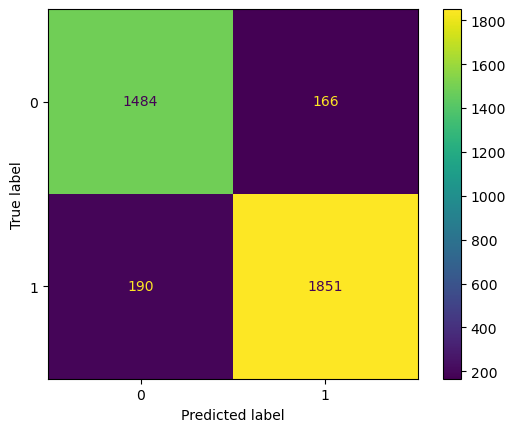

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
DTC_gini_y_pred = DTC_gini.predict(x_train.drop(columns='Unnamed: 0'))
ConfusionMatrixDisplay.from_predictions(y_train.drop(columns='Unnamed: 0'),DTC_gini_y_pred)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


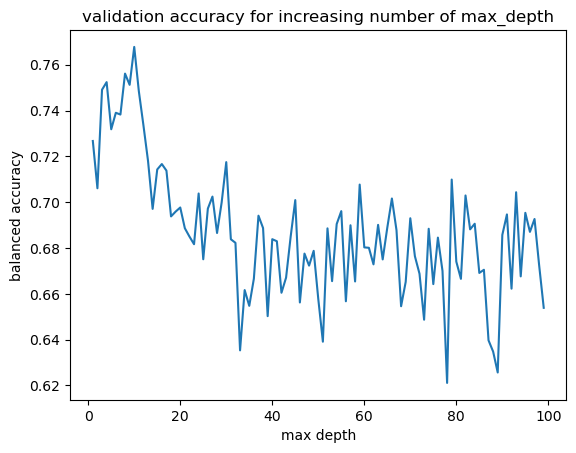

In [5]:
#learning curve
acc_list = []
i_list = []
for i in range(1,100): #number of iterations:
    print(i)
    DTC_gini_i = DecisionTreeClassifier(criterion='gini', max_depth=i) #new GINI model with i learning depth
    DTC_gini_i.fit(x_train.drop(columns='Unnamed: 0'), y_train.drop(columns='Unnamed: 0')) #fit the model to training data.
    
    DTC_gini_pred_val = DTC_gini_i.predict(x_val.drop(columns='Unnamed: 0'))
    DTC_gini_acc_val = metrics.balanced_accuracy_score(y_val.drop(columns='Unnamed: 0'), DTC_gini_pred_val)
    acc_list.append(DTC_gini_acc_val)
    i_list.append(i)
plt.plot(i_list, acc_list)
plt.title('validation accuracy for increasing number of max_depth')
plt.xlabel('max depth')
plt.ylabel('balanced accuracy')
plt.show()


# DTC_gini.fit(x_train.drop(columns='Unnamed: 0'), y_train.drop(columns='Unnamed: 0'))
# get_model_metrics(x_train, y_train, DTC_gini)
# get_model_metrics(x_val,y_val,DTC_gini)

In [6]:
for i in i_list:
    print(i, acc_list[i-1])
    #i = 10 is the best!

1 0.7267197140056507
2 0.7060773799227353
3 0.7490918526206538
4 0.7524073113071557
5 0.73182263737531
6 0.7390301562590094
7 0.7382517442195698
8 0.7561263910511445
9 0.7512252782102289
10 0.7677737415672029
11 0.7484575909588883
12 0.7335524419073978
13 0.717984201118607
14 0.6970823963558785
15 0.7142939514501527
16 0.7166580176440063
17 0.7137750100905265
18 0.6937957677449115
19 0.6959003632589518
20 0.6976878279421093
21 0.6886351842241827
22 0.6850025947067981
23 0.6816583059447616
24 0.7037998039554864
25 0.6750850487228277
26 0.6971977166580177
27 0.7024447904053508
28 0.6865594187856772
29 0.6998789136827539
30 0.7174940898345153
31 0.6838205616098714
32 0.6822637375309923
33 0.6353283745603413
34 0.6616502335236119
35 0.6547598454707951
36 0.6666090065155971
37 0.6941128985757943
38 0.688721674450787
39 0.6502623536873666
40 0.6838493916854063
41 0.6829556593438275
42 0.6604682004266851
43 0.6670702877241539
44 0.6850025947067981
45 0.7009167964020065
46 0.6562301793230698
4

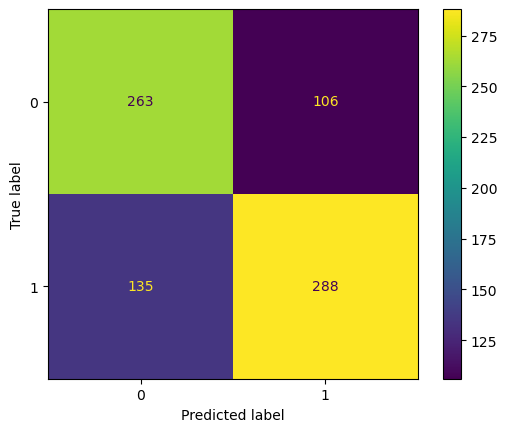

In [10]:
DTC_gini_10 = DecisionTreeClassifier(criterion='gini', max_depth=10) #new GINI model with i learning depth
DTC_gini_10.fit(x_train.drop(columns='Unnamed: 0'), y_train.drop(columns='Unnamed: 0'))
ConfusionMatrixDisplay.from_predictions(y_val.drop(columns='Unnamed: 0'),DTC_gini_10.predict(x_val.drop(columns='Unnamed: 0')))

this isn't great. Who knows?

In [21]:
#find the recall and F1 score to present.
DTC_gini_10_test_pred = DTC_gini_10.predict(x_test.drop(columns='Unnamed: 0'))
DTC_gini_10_test_pred_f1 = metrics.f1_score(y_test.drop(columns='Unnamed: 0'), DTC_gini_pred_val)
DTC_gini_10_test_pred_recall = metrics.balanced_accuracy_score(y_test.drop(columns='Unnamed: 0'), DTC_gini_pred_val)

In [22]:
print(f'recall test {DTC_gini_10_test_pred_recall}')
print(f'f1 test {DTC_gini_10_test_pred_f1}')

recall test 0.5181525735294118
f1 test 0.5571095571095571


Text(0.5, 1.0, 'confusion matrix for 10 depth, on test data')

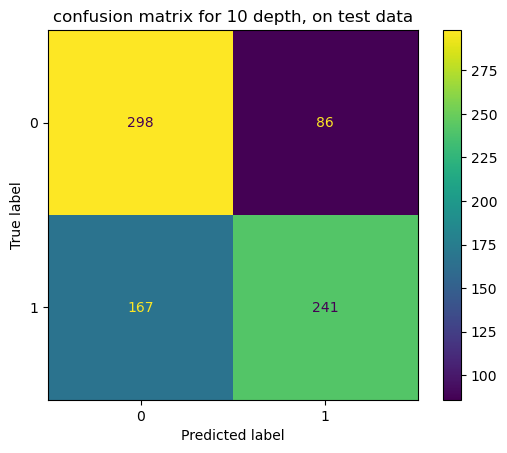

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test.drop(columns='Unnamed: 0'),DTC_gini_10.predict(x_test.drop(columns='Unnamed: 0')))
plt.title('confusion matrix for 10 depth, on test data')

# More hyperparameter tuning

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error


In [48]:
param_grid = {
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tuning_DTC = DecisionTreeClassifier(random_state=0)
grid_search = GridSearchCV(estimator=tuning_DTC, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='balanced_accuracy')

grid_search.fit(x_train, y_train)
best_dtree_reg = grid_search.best_estimator_ # Get the best estimator from the grid search
y_pred = best_dtree_reg.predict(x_test)
bacc = metrics.balanced_accuracy_score(y_test, y_pred)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"bacc: {bacc}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits


KeyboardInterrupt: 

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test RMSE: 1483.7467205719718

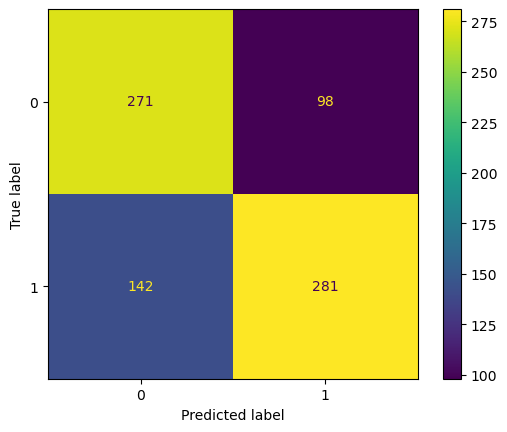

In [ ]:
DTC_gini_best = DecisionTreeClassifier(criterion='gini', max_depth=10,min_samples_leaf=1,min_samples_split=2) #new GINI model with i learning depth
DTC_gini_best.fit(x_train.drop(columns='Unnamed: 0'), y_train.drop(columns='Unnamed: 0'))
ConfusionMatrixDisplay.from_predictions(y_val.drop(columns='Unnamed: 0'),DTC_gini_best.predict(x_val.drop(columns='Unnamed: 0')))

DTC_gini_best_test_pred = DTC_gini_best.predict(x_test.drop(columns='Unnamed: 0'))
DTC_gini_best_test_pred_f1 = metrics.f1_score(y_test.drop(columns='Unnamed: 0'), DTC_gini_best_test_pred)
DTC_gini_best_test_pred_bacc = metrics.balanced_accuracy_score(y_test.drop(columns='Unnamed: 0'), DTC_gini_best_test_pred)